# Proyecto 1 - Juan Luis Baldelomar Cabrera

In [1]:
import pandas
import numpy as np

from nltk import TweetTokenizer
from nltk.corpus import stopwords

from nltk.probability import FreqDist

# Load Data

In [2]:
import pandas
xls = pandas.ExcelFile('Opiniones Tripadvisor_nlp2022.xlsx')
ds1, ds1_name = pandas.read_excel(xls, 'BasilicaColegiata'), 'Basilica Colegiata'
ds2, ds2_name = pandas.read_excel(xls, 'MercadoHidalgo'),    'Mercado Hidalgo'
ds3, ds3_name = pandas.read_excel(xls, 'CasaDiegoRivera'),   'Casa de Diego Rivera'
ds4, ds4_name = pandas.read_excel(xls, 'UG'),                'Universidad de Guanajuato'
ds5, ds5_name = pandas.read_excel(xls, 'Alhondiga'),         'Alhondiga'
ds6, ds6_name = pandas.read_excel(xls, 'TeatroJuarez'),      'Teatro Juarez'
ds7, ds7_name = pandas.read_excel(xls, 'JardinUnion'),       'Jardin Union'
ds8, ds8_name = pandas.read_excel(xls, 'CallejonBeso'),      'Callejon del Beso'
ds9, ds9_name = pandas.read_excel(xls, 'Pipila'),            'Monumento al Pipila'
ds10, ds10_name = pandas.read_excel(xls, 'MuseoMomias'),     'Museo de las Momias'

In [3]:
ds1

,Género,Edad,Nacional ó Internacional,Calificación,Escala,Número de aportaciones,Título de la opinión,Opinión,País,Idioma,Dispositivo,Fecha
0,Femenino,64.0,Internacional,Muy bueno,4,175,"""Punto central""","""Basílica muy bien conservada, punto central e...",Colombia,Español,Móvil,2018-05-13
1,Masculino,59.0,Internacional,Excelente,5,306,"""The most important church in this colonial to...","""The Basilica (Guanajuato does not have a Cath...",Colombia,Inglés,PC,2018-05-08
2,Femenino,26.0,Internacional,Excelente,5,106,"""Y uno de los símbolos de Guanajuato""","""Edificio de la iglesia amarilla es un abigarr...",Corea del Sur,Coreano,PC,2018-05-05
3,Masculino,50.0,Internacional,Excelente,5,62,"""Beautiful and a must see""","""A must see place in town and very nice to go ...",Estados Unidos,Inglés,PC,2018-05-01
4,Femenino,55.0,Internacional,Regular,3,59,"""Nice""","""Not particularly impressive, but if you like ...",Estados Unidos,Inglés,PC,2018-04-29
...,...,...,...,...,...,...,...,...,...,...,...,...
555,Femenino,43.0,Nacional,Muy bueno,4,12,"""Hermosa iglesia""","""Es un sitio lleno de contrastes. Fuera del te...",México,Español,PC,2011-12-03
556,Masculino,38.0,Internacional,Excelente,5,11,"""Historical""","""I walked into the Basilica and felt suddenly ...",Canadá,Inglés,PC,2011-09-17
557,Femenino,23.0,Nacional,Excelente,5,2,"""Basílica de Nuestra Señora de Guanajuato""","""Un lugar al buen estilo barroco, puedes admir...",México,Español,PC,2011-09-11
558,Femenino,49.0,Nacional,Excelente,5,60,"""Beautiful Church""","""The inside of this Church in Plaza la Paz, is...",México,Inglés,PC,2011-09-02


In [4]:
datasets = [ds1, ds2, ds3, ds4, ds5, ds6, ds7, ds8, ds9, ds10]
ds_names = [ds1_name, ds2_name, ds3_name, ds4_name, ds5_name, ds6_name, ds7_name, ds8_name, ds9_name, ds10_name]

# Utilities

In [7]:
def bold_string(string):
    return '\033[1m' + string + '\033[0m '

def dummy(doc):
    return doc

In [8]:
from nltk import TweetTokenizer
from nltk.corpus import stopwords

def process_documents(documents):
    docs = []
    tokenizer = TweetTokenizer()
    for doc in documents:
        docs.append(tokenizer.tokenize(doc.lower().replace('\"','')))
        
    return docs

def get_vocabulary(docs, size=-1):
    tokens = [word for doc in docs for word in doc]
    voc = FreqDist(tokens).most_common(size) if size!= -1 else FreqDist(tokens).most_common()
    voc_dict = {}
    for i, (word, _) in enumerate(voc):
        voc_dict[word] = i
        
    return voc_dict

In [189]:
from sklearn.feature_extraction.text import CountVectorizer as bow_builder
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_selection import SelectKBest, chi2 
from sklearn.preprocessing import LabelBinarizer


def chi_sqr(tf_matrix, labels):
    Nt = len(tf_matrix)
    bin_labels = LabelBinarizer().fit_transform(labels)
    bin_labels = [bin_labels[:, i][:,np.newaxis] for i in range(bin_labels.shape[1])] 

    n_i = np.sum(tf_matrix>0, axis=0)
    n_ic = np.array([np.sum((tf_matrix * bin_label)>0, axis=0) for bin_label in bin_labels])
    n_c = np.array([np.sum(bin_label) for bin_label in bin_labels])[:, np.newaxis]
    chi_c = Nt*(Nt * n_ic - n_c * n_i)**2/(n_c * n_i * (Nt - n_c) * (Nt - n_i))
    
    return chi_c

def reduce_dims(bow, voc, labels, n, label_pos):
    # compute chi avg
    chi = chi_sqr(bow, labels)
    new_dict = {}
    n_max_chi = np.flip(np.argsort(chi[label_pos]))[:n]
    
    for i, index in enumerate(n_max_chi):
        word = voc[index]
        new_dict[word] = i
        
    chi_pos = chi[label_pos][n_max_chi]
    return new_dict, chi_pos


def get_bow(documents, T=10000, transform=False, use_idf=False, vocabulary=None, sw=None):
    bow_b = bow_builder(max_features=T, vocabulary=vocabulary, binary=False, stop_words=sw)
    tfidf = TfidfTransformer(use_idf=use_idf)
    
    bow = bow_b.fit_transform(documents) if vocabulary == None else bow_b.transform(documents)
    if transform:
        bow = tfidf.fit_transform(bow)
        
    return bow, bow_b.get_feature_names_out()

def get_features_by_hand(documents, labels, label_pos, n, T=10000, sw=None):
    bow, voc = get_bow(documents, T=T, sw=sw)
    return reduce_dims(bow.toarray(), voc, labels, n, label_pos)
    
def get_features(documents, labels, n, T=10000, use_idf=False, vocabulary=None, sw=None):
    bow, features = get_bow(documents, T, use_idf, vocabulary, sw)
    discriminator = SelectKBest(chi2, k=n)
    X = discriminator.fit_transform(bow, labels)
    scores = discriminator.scores_
    features = discriminator.get_feature_names_out(features)
    
    return X, scores, features

In [131]:
docs = [['hola', 'mundo'],['documento','hola','numero', '2', 'orale'],['que', 'hola','bonito', 'es', 'lo', 'bonito']]
labels = [1, 0, 0]
vocabulary = get_vocabulary(docs)
bow_b = bow_builder(max_features=10, vocabulary=None, binary=False, tokenizer=dummy, preprocessor=dummy, stop_words=['lo'])
bow = bow_b.fit_transform(docs)

tfidf = TfidfTransformer(use_idf=True, smooth_idf=False)


getFeat = SelectKBest(chi2, k=5)

X = getFeat.fit_transform(bow, labels)

getFeat.get_feature_names_out(bow_b.get_feature_names_out())

/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['l', 'o'] not in stop_words.
  warnings.warn(


AttributeError: 'list' object has no attribute 'lower'

In [143]:
np.sum(LabelBinarizer().fit_transform([1, 1, 2, 2, 0, 1, 2, 5])[:,0][:,np.newaxis])

1

In [114]:
bow.toarray()

array([[0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [1, 0, 1, 0, 1, 0, 0, 1, 1, 0],
       [0, 2, 0, 1, 1, 1, 0, 0, 0, 1]])

In [113]:
tfidf.fit_transform(bow).toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.43016528,
        0.        , 0.90275015, 0.        , 0.        , 0.        ],
       [0.48638585, 0.        , 0.48638585, 0.        , 0.23176546,
        0.        , 0.        , 0.48638585, 0.48638585, 0.        ],
       [0.        , 0.74395942, 0.        , 0.37197971, 0.17725032,
        0.37197971, 0.        , 0.        , 0.        , 0.37197971]])

0.9999999966439369

In [55]:
chi2(bow, labels)

(array([2., 4., 2., 2., 2., 2., 2., 2., 2., 2.]),
 array([0.36787944, 0.13533528, 0.36787944, 0.36787944, 0.36787944,
        0.36787944, 0.36787944, 0.36787944, 0.36787944, 0.36787944]))

In [110]:
bow_b.get_feature_names_out()

array(['2', 'bonito', 'documento', 'es', 'hola', 'lo', 'mundo', 'numero',
       'orale', 'que'], dtype=object)

In [91]:
bow.toarray().shape

(3, 10)

In [70]:
getFeat.scores_

array([0.5, 1. , 0.5, 0.5, 2. , 0.5, 2. , 0.5, 0.5, 0.5])

In [71]:
X.toarray()

array([[0, 1, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [2, 0, 0, 0, 1]])

In [22]:
bow.toarray()

array([[0, 0, 0, 0, 1],
       [1, 0, 1, 0, 0],
       [0, 2, 0, 1, 0]])

# 1. Estadísticas

## Promedio de Puntuación

In [43]:
for ds, name in zip(datasets, ds_names):
    scores = np.array(list(map(int, ds['Escala'])))
    print('{0:40} puntuación media: {1:.2f} \t std dev: {2:.2f}'.format(bold_string(name), np.mean(scores), np.std(scores)))

Basilica Colegiata               puntuación media: 4.50 	 std dev: 0.67
Mercado Hidalgo                  puntuación media: 3.95 	 std dev: 0.95
Casa de Diego Rivera             puntuación media: 4.24 	 std dev: 0.80
Universidad de Guanajuato        puntuación media: 4.60 	 std dev: 0.61
Alhondiga                        puntuación media: 4.45 	 std dev: 0.75
Teatro Juarez                    puntuación media: 4.70 	 std dev: 0.52
Jardin Union                     puntuación media: 4.59 	 std dev: 0.61
Callejon del Beso                puntuación media: 4.00 	 std dev: 0.97
Monumento al Pipila              puntuación media: 4.38 	 std dev: 0.77
Museo de las Momias              puntuación media: 3.68 	 std dev: 1.14


## Longitud Promedio de Comentarios

In [143]:
for ds, name in zip(datasets, ds_names):
    opinions = list(ds['Opinión'])
    opinions = process_documents(opinions)
    opinion_nWords = np.array([len(opinion) for opinion in opinions])
    print('{0:40} longitud media de opiniones: {1:.2f} \t std dev: {2:.2f}'.format(bold_string(name), np.mean(opinion_nWords), np.std(opinion_nWords)))

Basilica Colegiata               longitud media de opiniones: 44.31 	 std dev: 32.48
Mercado Hidalgo                  longitud media de opiniones: 51.62 	 std dev: 37.96
Casa de Diego Rivera             longitud media de opiniones: 54.73 	 std dev: 33.51
Universidad de Guanajuato        longitud media de opiniones: 39.44 	 std dev: 22.18
Alhondiga                        longitud media de opiniones: 51.53 	 std dev: 37.29
Teatro Juarez                    longitud media de opiniones: 46.43 	 std dev: 29.84
Jardin Union                     longitud media de opiniones: 48.76 	 std dev: 41.60
Callejon del Beso                longitud media de opiniones: 50.34 	 std dev: 36.20
Monumento al Pipila              longitud media de opiniones: 52.78 	 std dev: 40.04
Museo de las Momias              longitud media de opiniones: 65.07 	 std dev: 51.82


## Promedio de Edades

In [42]:
for ds, name in zip(datasets, ds_names):
    scores = np.array(list(map(float, ds['Edad'])))
    print('{0:40} edad media: {1:.2f} \t std dev: {2:.2f}'.format(bold_string(name), np.nanmean(scores), np.nanstd(scores)))

Basilica Colegiata               edad media: 41.87 	 std dev: 14.82
Mercado Hidalgo                  edad media: 40.69 	 std dev: 15.07
Casa de Diego Rivera             edad media: 44.35 	 std dev: 15.11
Universidad de Guanajuato        edad media: 39.31 	 std dev: 13.92
Alhondiga                        edad media: 40.71 	 std dev: 13.34
Teatro Juarez                    edad media: 41.75 	 std dev: 13.81
Jardin Union                     edad media: 41.39 	 std dev: 14.88
Callejon del Beso                edad media: 38.83 	 std dev: 13.33
Monumento al Pipila              edad media: 38.44 	 std dev: 13.05
Museo de las Momias              edad media: 38.96 	 std dev: 12.88


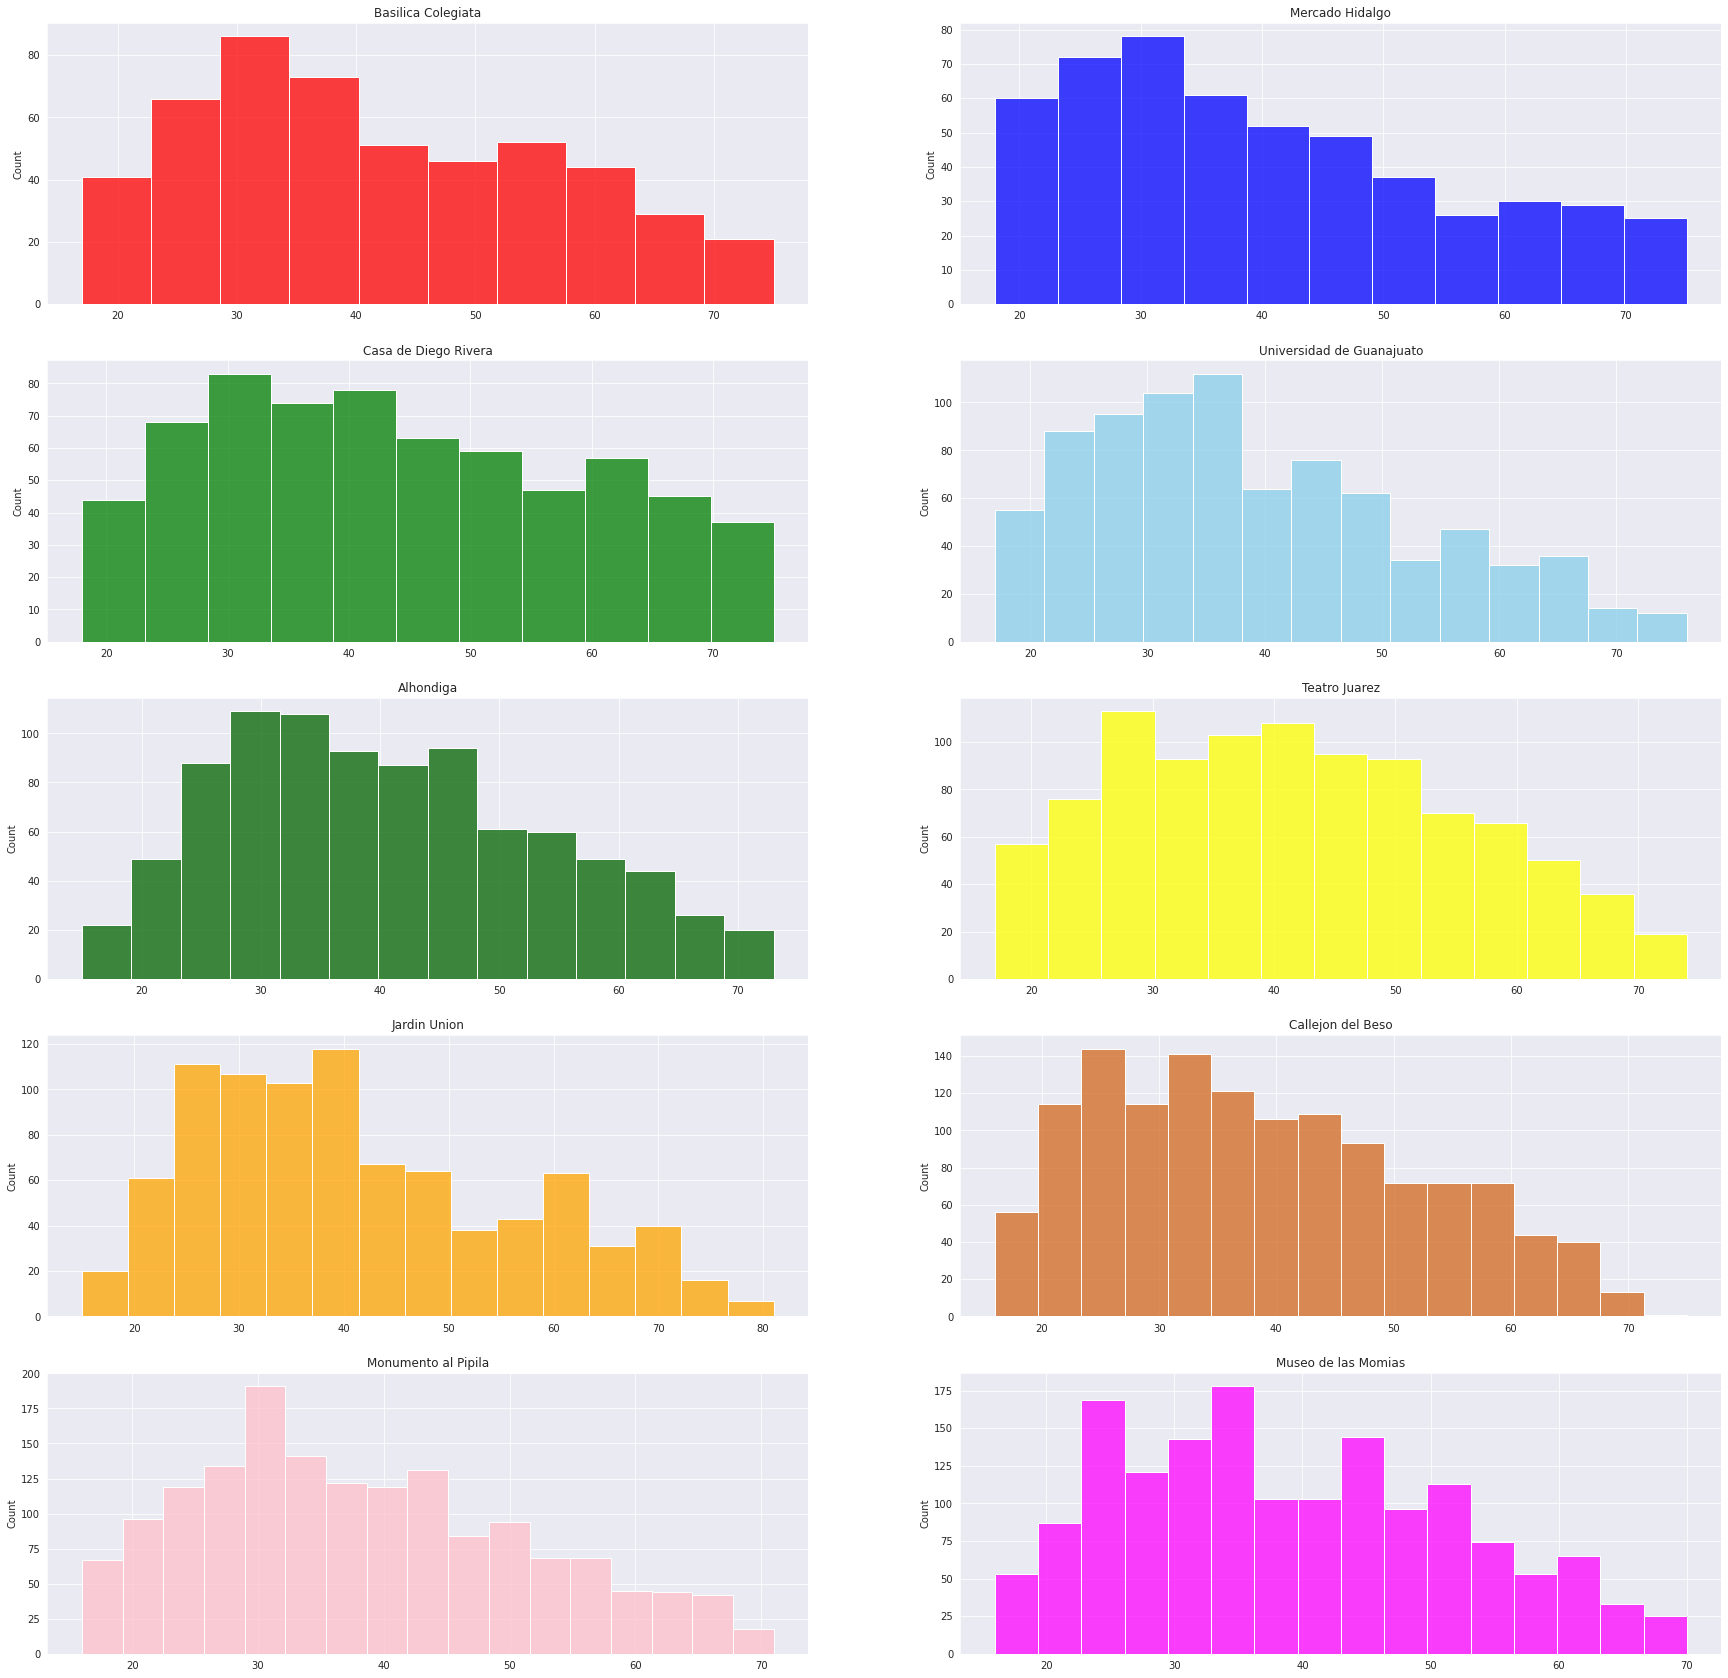

In [133]:
%matplotlib inline
import matplotlib.pyplot as plt

# get figure and axis
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(30, 30))
# linearize axis
axs = [a for ax in axs for a in ax]

colors = ['red', 'blue', 'green', 'skyblue', 'darkgreen', 'yellow', 'orange', 'chocolate', 'pink', 'magenta']
for ds, name, ax, color in zip(datasets, ds_names, axs, colors):
    ages = np.array(list(map(float, ds['Edad'])))
    sns.set_style('darkgrid')
    sns.histplot(ages, ax=ax, color=color).set(title=name)

## Histograma de Cantidad de Personas Nacionales o Internacionales

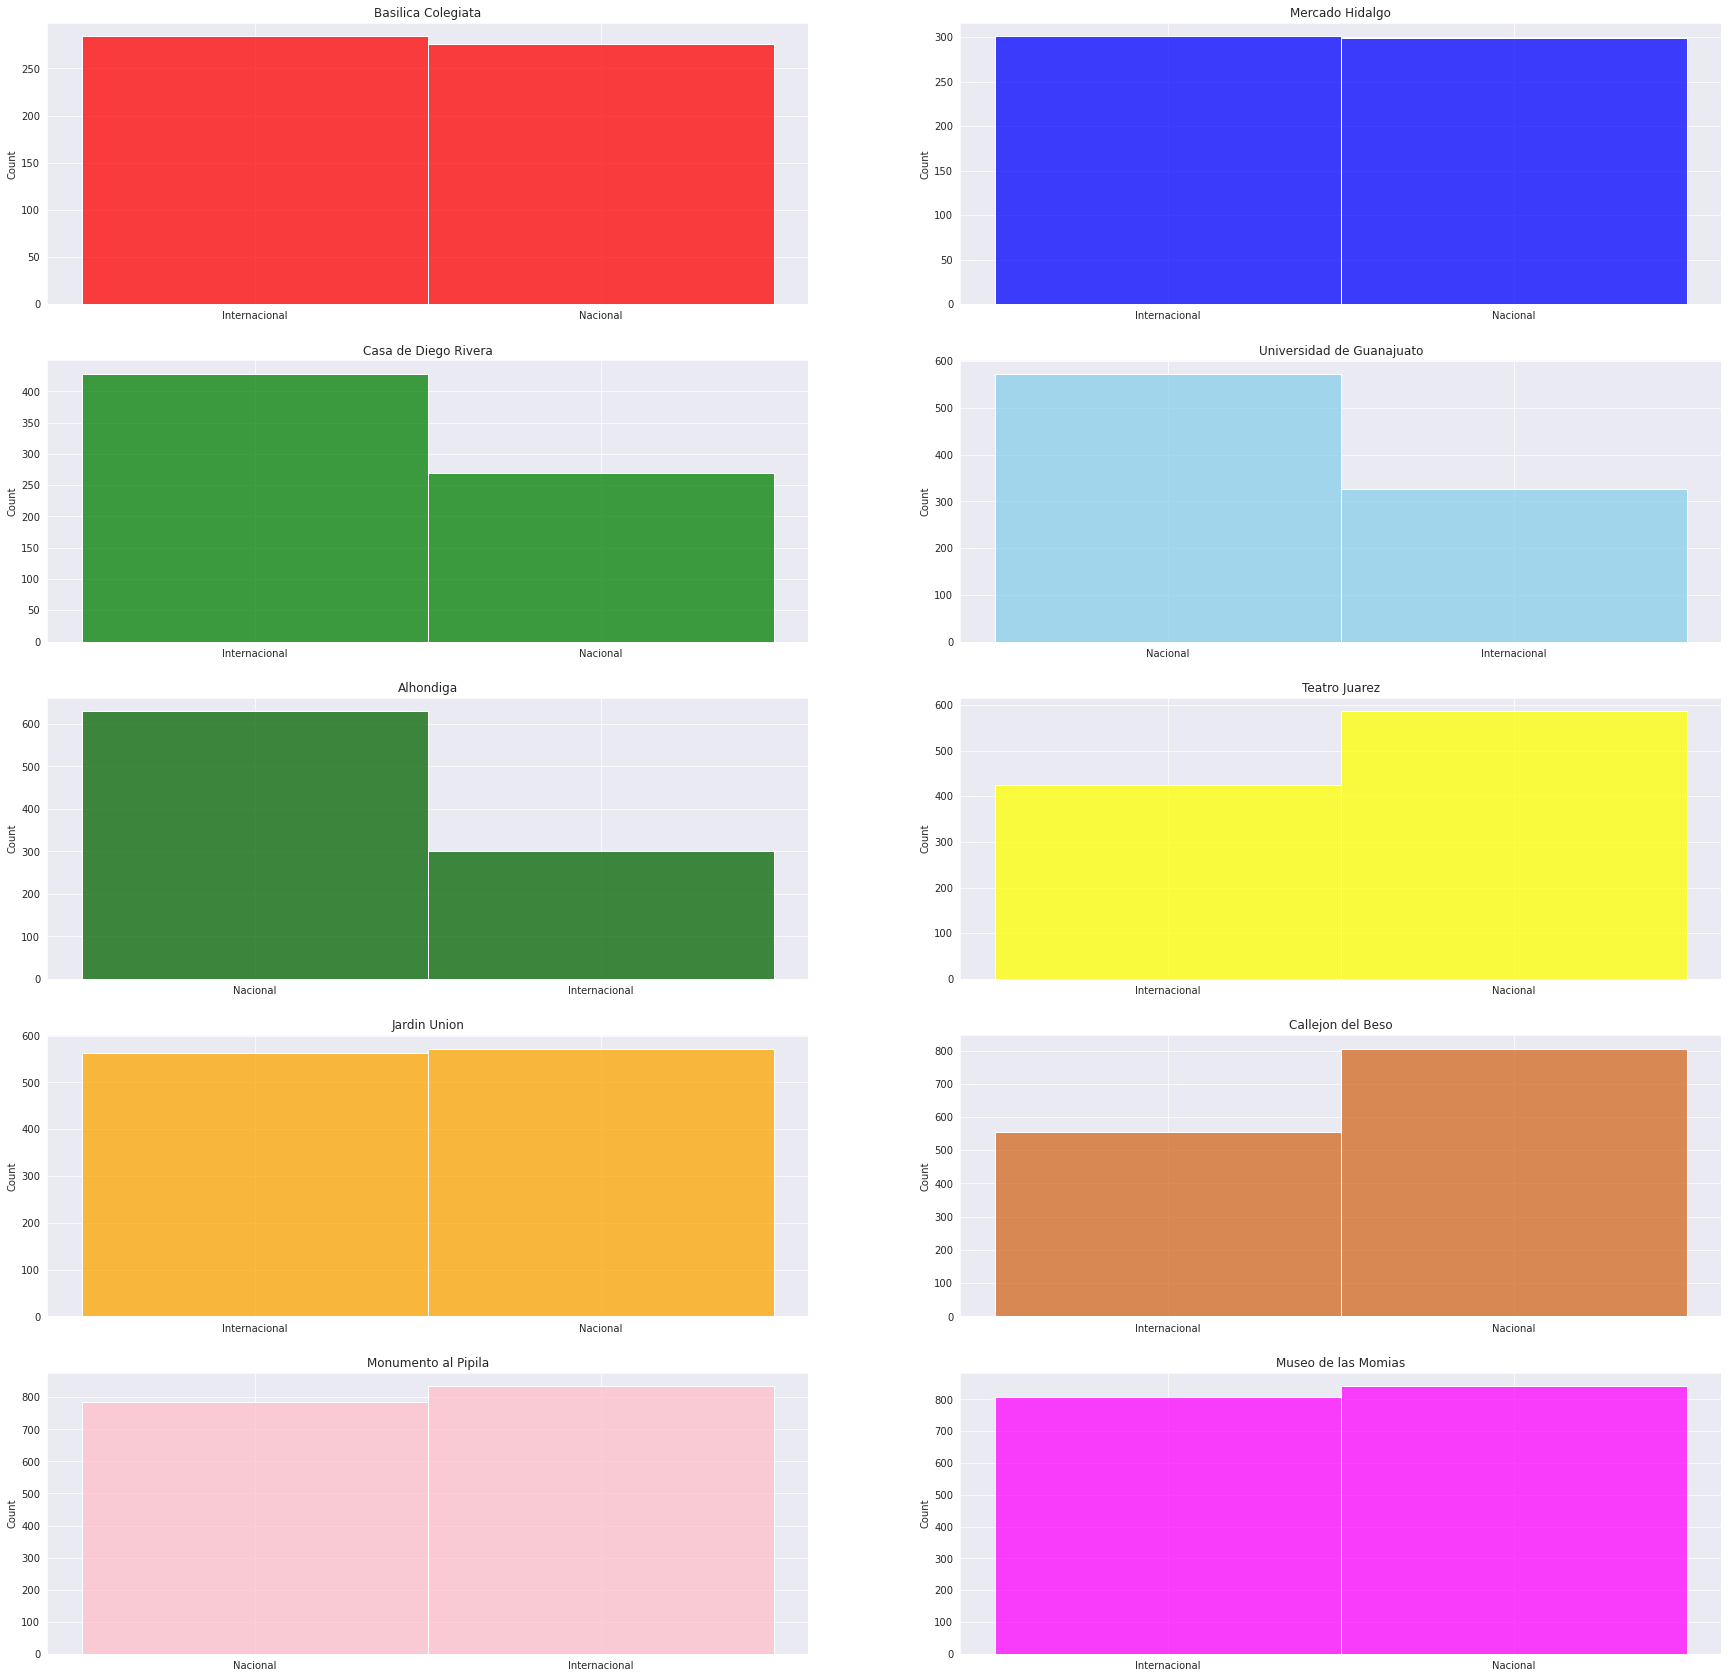

In [132]:
# get figure and axis
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(30, 30))
# linearize axis
axs = [a for ax in axs for a in ax]

colors = ['red', 'blue', 'green', 'skyblue', 'darkgreen', 'yellow', 'orange', 'chocolate', 'pink', 'magenta']
for ds, name, ax, color in zip(datasets, ds_names, axs, colors):
    places = list(ds['Nacional ó Internacional'])
    sns.set_style('darkgrid')
    sns.histplot(places, ax=ax, color=color).set(title=name)

## Histograma de Países

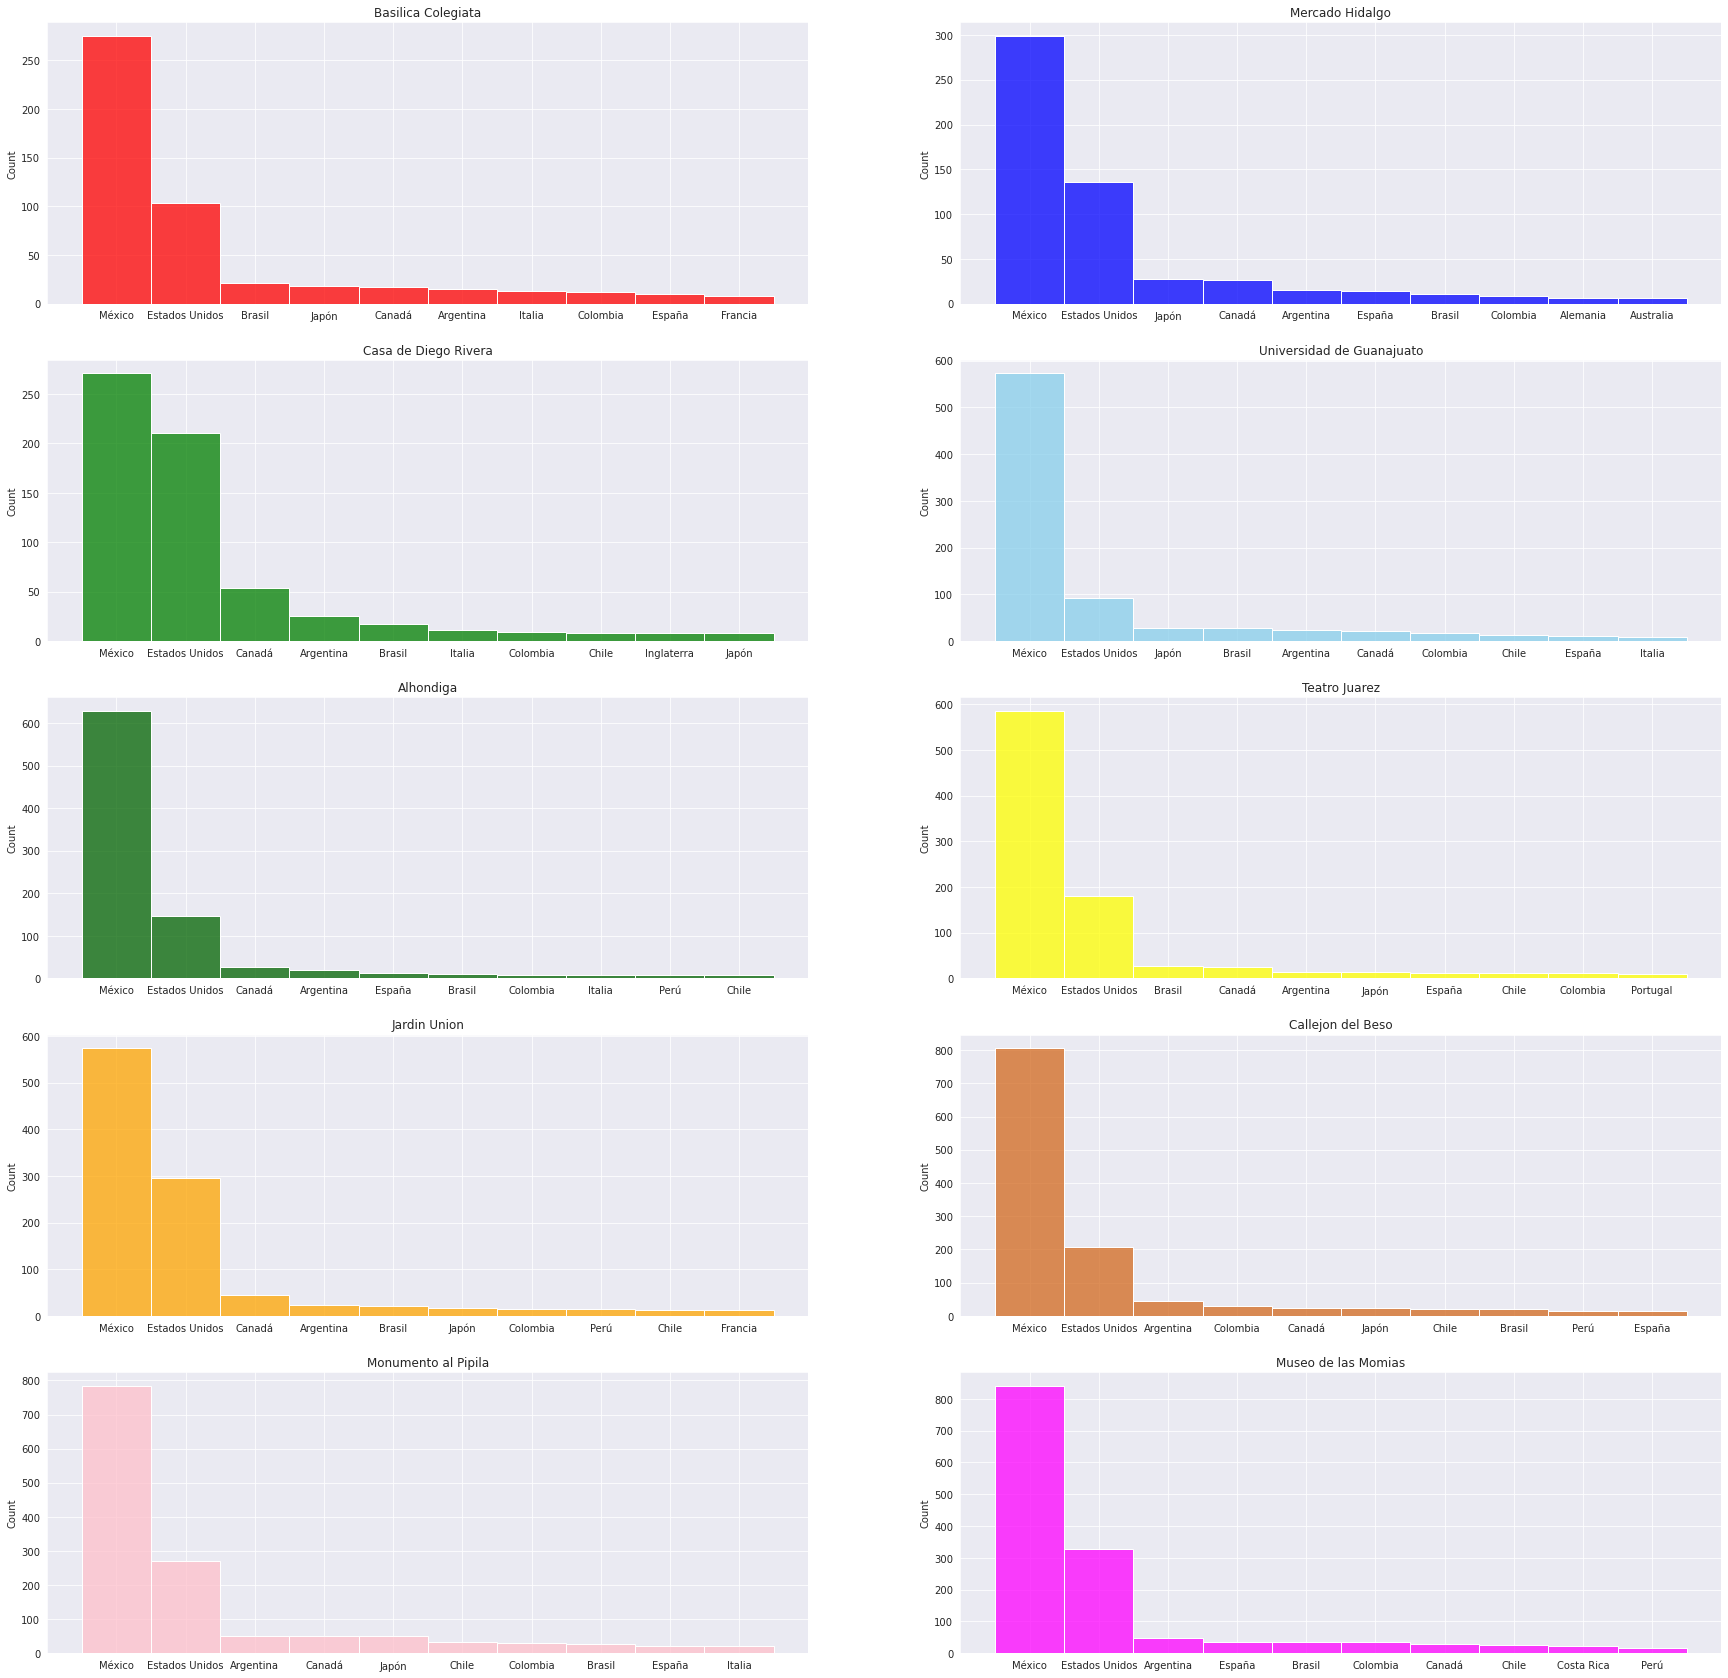

In [131]:
# get figure and axis
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(30, 30))
# linearize axis
axs = [a for ax in axs for a in ax]

colors = ['red', 'blue', 'green', 'skyblue', 'darkgreen', 'yellow', 'orange', 'chocolate', 'pink', 'magenta']
for ds, name, ax, color in zip(datasets, ds_names, axs, colors):
    countries = list(ds['País'])
    countries = FreqDist(countries).most_common(10)
    countries = [word for word, count in countries for _ in range(count)]
    sns.set_style('darkgrid')
    sns.histplot(countries, ax=ax, color=color).set(title=name)

## Histograma por Género

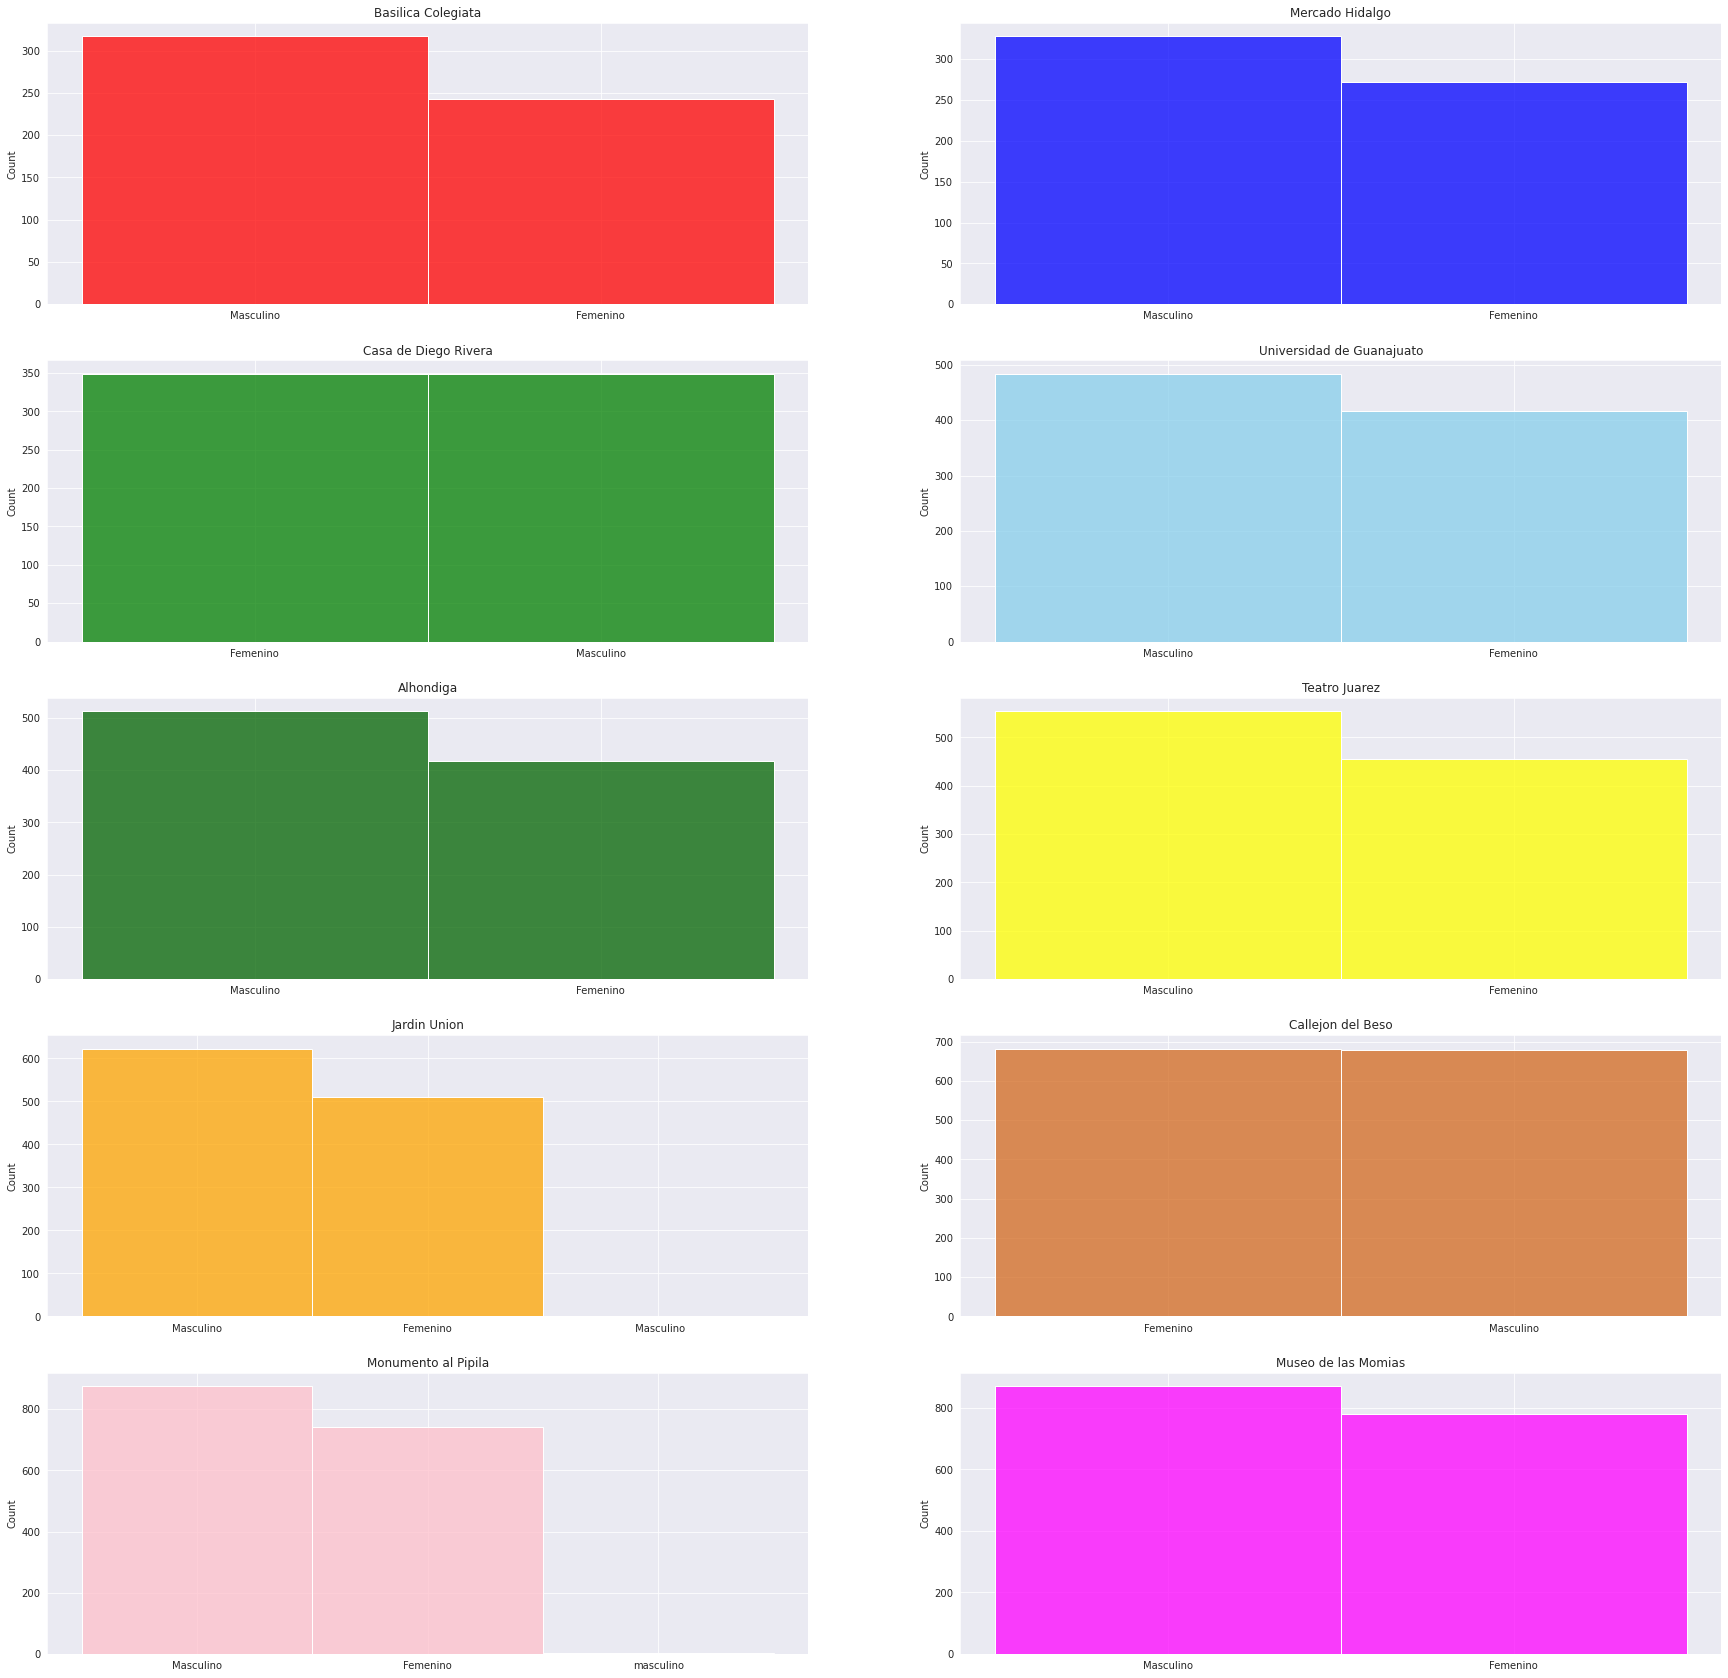

In [136]:
# get figure and axis
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(30, 30))
# linearize axis
axs = [a for ax in axs for a in ax]

colors = ['red', 'blue', 'green', 'skyblue', 'darkgreen', 'yellow', 'orange', 'chocolate', 'pink', 'magenta']
for ds, name, ax, color in zip(datasets, ds_names, axs, colors):
    countries = list(ds['Género'])
    countries = FreqDist(countries).most_common(10)
    countries = [word for word, count in countries for _ in range(count)]
    sns.set_style('darkgrid')
    sns.histplot(countries, ax=ax, color=color).set(title=name)

# 2. Nubes de Palabras

In [132]:
def get_docs(preprocess=False):
    docs_by_place = []
    labels_by_place = []
    for ds in datasets:
        docs = list(ds['Opinión'])
        # get labels
        scores = np.array(list(map(int, ds['Escala'])))
        scores_mat = np.row_stack((scores>=4, scores==3, scores<3))
        labels = 0 * scores_mat[0] + 1*scores_mat[1] + 2 * scores_mat[2]
        # process docs
        if preprocess:
            docs = process_documents(docs)
        # append values
        docs_by_place.append(docs)
        labels_by_place.append(labels)
        
    return docs_by_place, labels_by_place

In [135]:
docs_by_place, labels_by_place = get_docs()

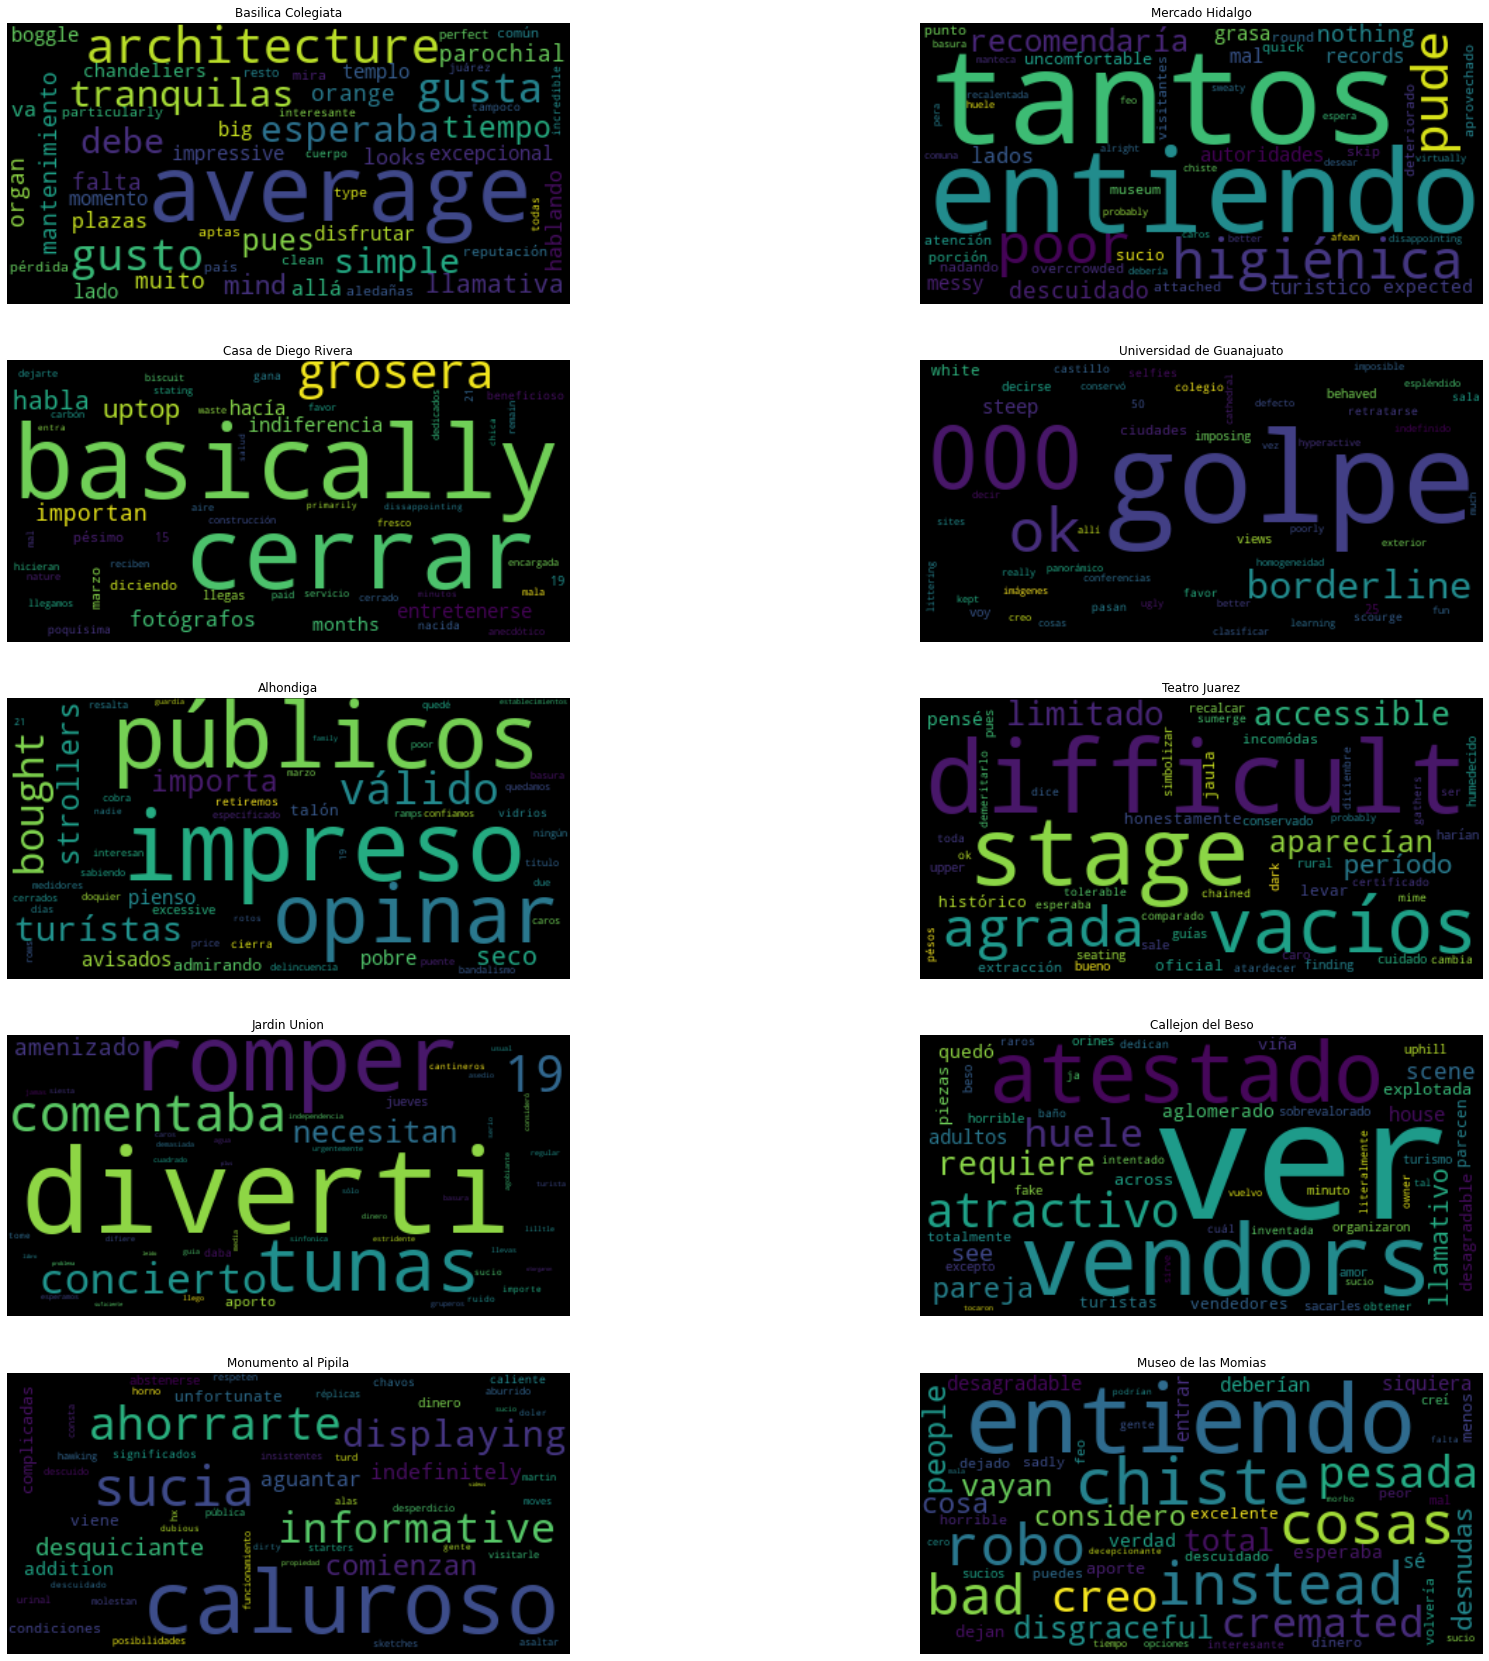

In [136]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

# get stopwrds
sw = stopwords.words('spanish') + stopwords.words('english')

# get axis for figures
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(30, 30))
# linearize axis
axs = [a for ax in axs for a in ax]

for docs, labels, name, ax in zip(docs_by_place, labels_by_place, ds_names, axs):
    vocabulary = get_vocabulary(docs)
    _, scores, features = get_features(docs, labels, 50, sw=sw)
    
    frequencies = {}
    for (word, weight) in zip(features, scores):
        frequencies[word] = weight
        
    # Generate a word cloud image
    wordcloud = WordCloud().generate_from_frequencies(frequencies)
    # plot 
    ax.imshow(wordcloud, interpolation='bilinear', )
    ax.axis("off")
    ax.set_title(name)
    

# 4. Nube de Palabras Negativas

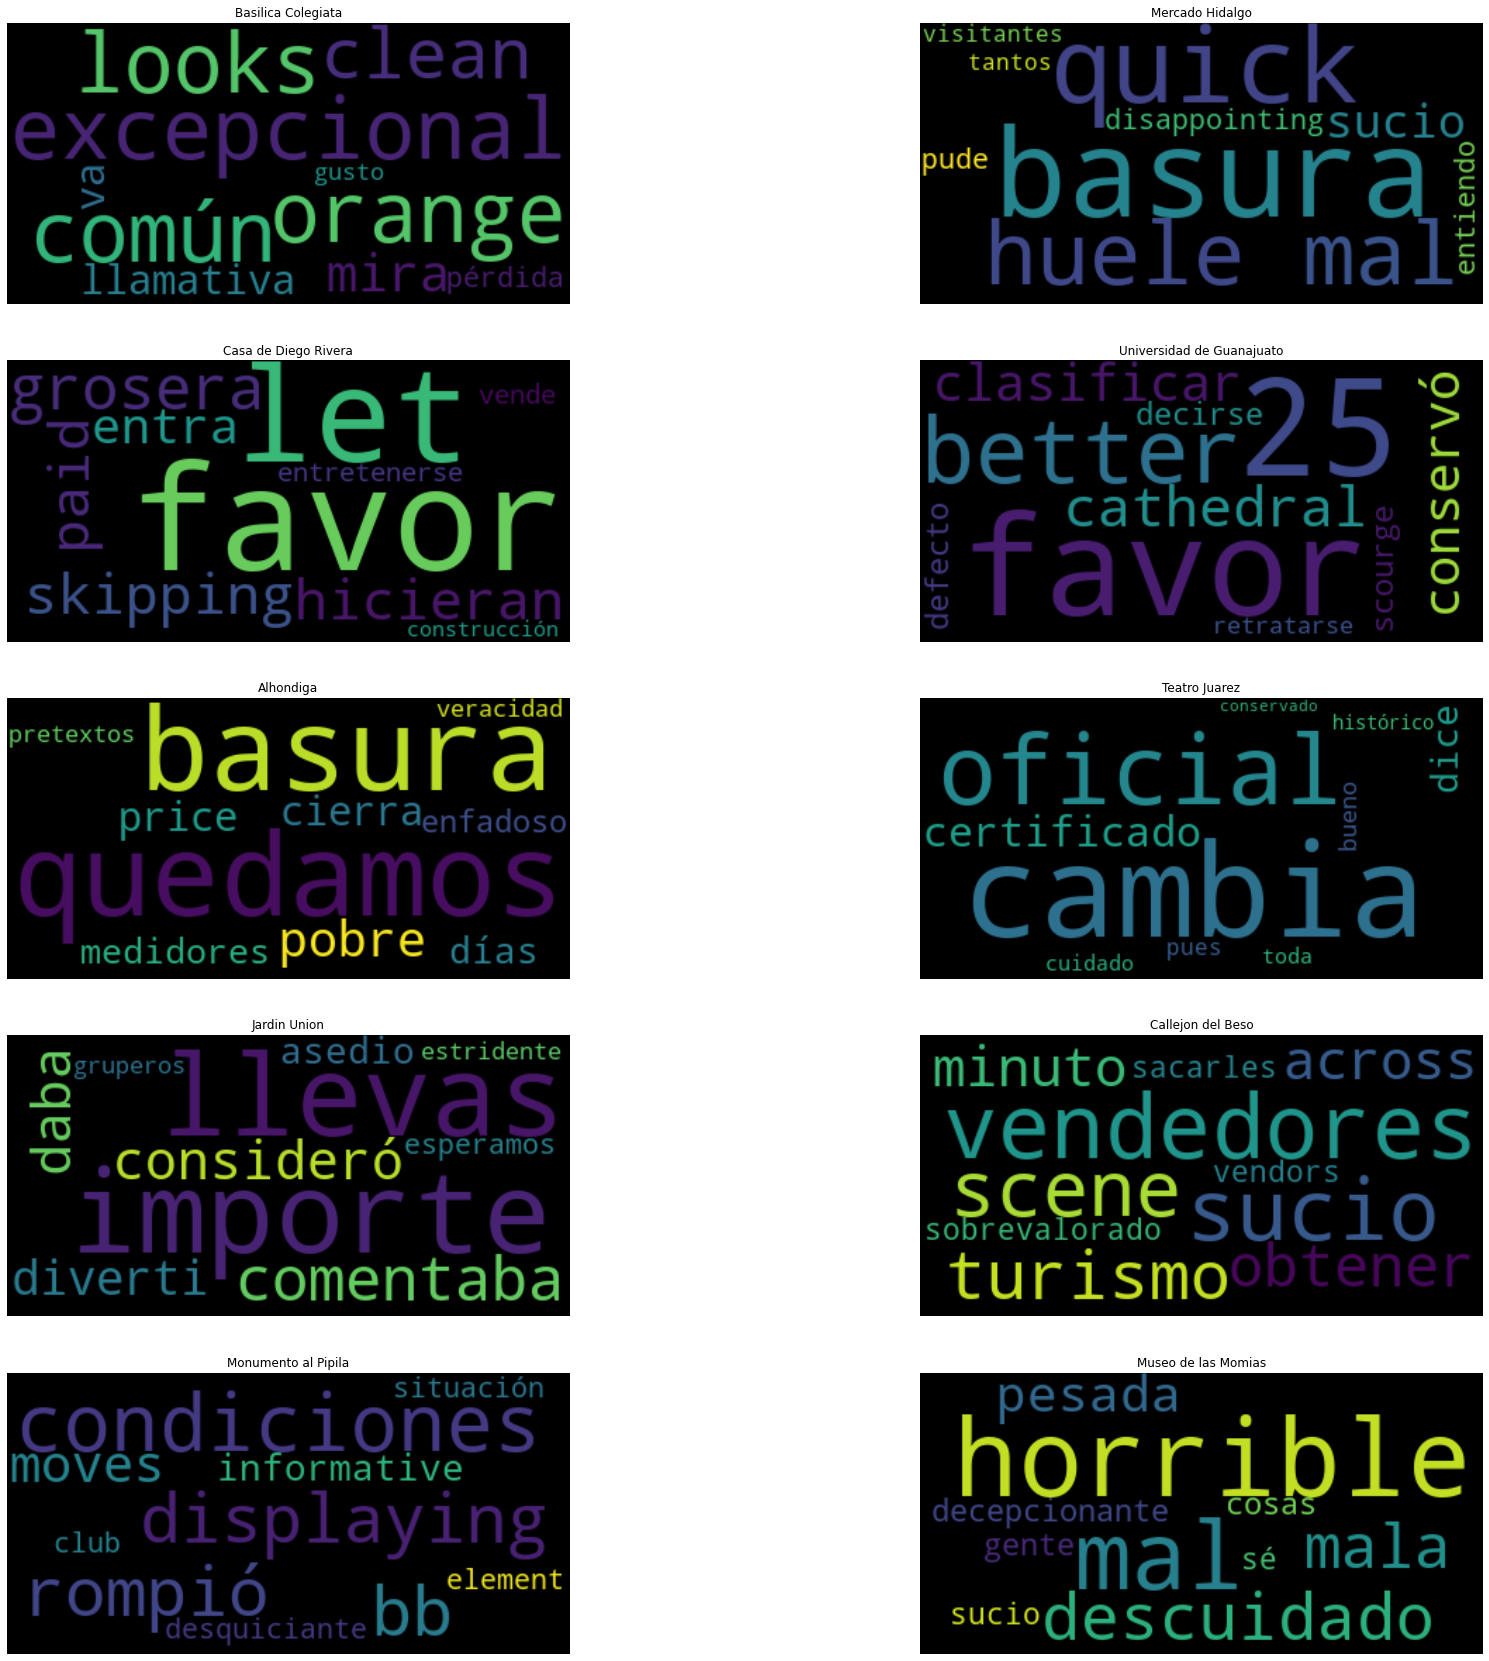

In [193]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

# get stopwrds
sw = stopwords.words('spanish') + stopwords.words('english')

# get axis for figures
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(30, 30))
# linearize axis
axs = [a for ax in axs for a in ax]

for docs, labels, name, ax in zip(docs_by_place, labels_by_place, ds_names, axs):
    vocabulary = get_vocabulary(docs)
    features, scores = get_features_by_hand(docs, labels, 2, 10, sw=sw)
    
    frequencies = {}
    for (word, weight) in zip(features.keys(), scores):
        frequencies[word] = weight
        
    # Generate a word cloud image
    wordcloud = WordCloud().generate_from_frequencies(frequencies)
    # plot 
    ax.imshow(wordcloud, interpolation='bilinear', )
    ax.axis("off")
    ax.set_title(name)
    

# Pruebas

In [175]:
tf_matrix = np.random.choice([0, 1, 2, 3], (10, 10))
labels = [1, 0, 0, 0, 0, 0, 0, 0, 0, 2]

Nt = len(tf_matrix)
bin_labels = LabelBinarizer().fit_transform(labels)
bin_labels = [bin_labels[:, i][:,np.newaxis] for i in range(bin_labels.shape[1])] 

n_i = np.sum(tf_matrix>0, axis=0)
n_ic = np.array([np.sum((tf_matrix * bin_label)>0, axis=0) for bin_label in bin_labels])
n_c = np.array([np.sum(bin_label) for bin_label in bin_labels])[:, np.newaxis]

labels = np.array(labels)[:, np.newaxis]

n_i1 = np.sum((tf_matrix * labels)>0, axis=0)
n_i0 = np.sum((tf_matrix * (1-labels))>0, axis=0)

n_1 = np.sum(labels, axis=0)
n_0 = Nt - n_1
                 
# compute chi
chi_1 = Nt*(Nt * n_i1 - n_1 * n_i)**2/(n_1 * n_i * (Nt - n_1) * (Nt - n_i))
chi_0 = Nt*(Nt * n_i0 - n_0 * n_i)**2/(n_0 * n_i * (Nt - n_0) * (Nt - n_i))

chi_c = Nt*(Nt * n_ic - n_c * n_i)**2/(n_c * n_i * (Nt - n_c) * (Nt - n_i))

                 

ni1 [2 1 2 1 2 1 2 2 2 1]
ni0 [5 5 7 6 7 5 5 6 5 5]
n1 [3]
n0 [7]


In [174]:
tf_matrix

array([[2, 3, 3, 1, 2, 1, 3, 1, 0, 0],
       [1, 1, 0, 2, 2, 0, 0, 1, 1, 1],
       [0, 0, 0, 3, 3, 3, 0, 3, 1, 0],
       [0, 1, 1, 1, 3, 1, 1, 3, 1, 0],
       [2, 1, 1, 1, 0, 2, 2, 3, 2, 2],
       [2, 2, 1, 3, 3, 2, 3, 2, 3, 3],
       [3, 3, 0, 3, 1, 0, 2, 3, 1, 3],
       [2, 3, 0, 1, 2, 3, 0, 0, 1, 3],
       [2, 0, 0, 1, 3, 3, 3, 3, 2, 0],
       [2, 2, 1, 0, 0, 0, 0, 2, 0, 2]])

In [176]:
chi_c

array([[1.07142857, 0.10416667, 0.27777778, 0.47619048, 0.27777778,
        0.10416667, 1.07142857, 0.625     , 1.07142857, 0.10416667],
       [0.47619048, 1.66666667, 0.12345679, 2.59259259, 0.12345679,
        1.66666667, 0.47619048, 0.27777778, 0.47619048, 0.74074074],
       [0.47619048, 0.74074074, 0.12345679, 0.47619048, 0.12345679,
        0.74074074, 0.47619048, 0.27777778, 0.47619048, 1.66666667]])

In [171]:
chi_0

array([4.44444444, 0.12345679, 0.12345679, 0.47619048, 1.66666667,
       0.27777778, 0.27777778, 1.11111111, 0.47619048, 0.12345679])

In [172]:
chi_1

array([4.44444444, 0.12345679, 0.12345679, 0.47619048, 1.66666667,
       0.27777778, 0.27777778, 1.11111111, 0.47619048, 0.12345679])

In [181]:
np.array([1, 4, 5]) * np.array([[1],[2], [3]])

array([[ 1,  4,  5],
       [ 2,  8, 10],
       [ 3, 12, 15]])